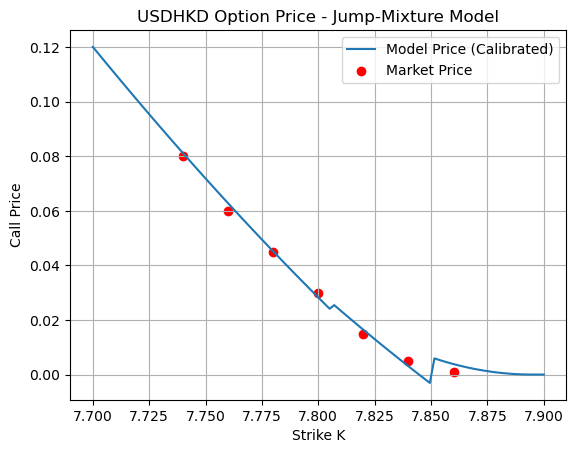

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# === PARAMETERS ===
a, b = 7.75, 7.85
S0, F = 7.80, 7.82
alpha = np.log(F / S0)
ratio = 1  # q = ratio * p

# === CORE FUNCTIONS ===
def determine_case(K, d):
    bounds = [a * np.exp(-d), b * np.exp(-d), a, b, a * np.exp(d), b * np.exp(d)]
    if K < bounds[0]: return 1
    elif bounds[0] <= K < bounds[1]: return 2
    elif bounds[1] <= K < bounds[2]: return 3
    elif bounds[2] <= K < bounds[3]: return 4
    elif bounds[3] <= K < bounds[4]: return 5
    elif bounds[4] <= K < bounds[5]: return 6
    else: return 7

def call_price_closed_form(K, p):
    if p <= 0 or p >= 1 / (1 + 2 * ratio): return np.nan
    d = alpha / (1 - p * (1 + 2 * ratio))
    q = ratio * p
    w0 = p
    w1 = 1 - p * (1 + ratio)
    ax_neg, bx_neg = a * np.exp(-d), b * np.exp(-d)
    Dx_neg = bx_neg - ax_neg
    ax_0, bx_0 = a, b
    Dx_0 = bx_0 - ax_0
    ax_pos, bx_pos = a * np.exp(d), b * np.exp(d)
    Dx_pos = bx_pos - ax_pos
    case = determine_case(K, d)

    if case == 1:
        phi_m1 = (ax_neg + bx_neg) / 2 - K
        phi_0 = (ax_0 + bx_0) / 2 - K
        phi_p1 = (ax_pos + bx_pos) / 2 - K
    elif case == 2:
        phi_m1 = (bx_neg - K)**2 / (2 * Dx_neg)
        phi_0 = (ax_0 + bx_0) / 2 - K
        phi_p1 = (ax_pos + bx_pos) / 2 - K
    elif case == 3:
        phi_m1 = 0.0
        phi_0 = (ax_0 + bx_0) / 2 - K
        phi_p1 = (ax_pos + bx_pos) / 2 - K
    elif case == 4:
        phi_m1 = 0.0
        phi_0 = (bx_0 - K)**2 / (2 * Dx_0)
        phi_p1 = (ax_pos + bx_pos) / 2 - K
    elif case == 5:
        phi_m1 = 0.0
        phi_0 = 0.0
        phi_p1 = (ax_pos + bx_pos) / 2 - K
    elif case == 6:
        phi_m1 = 0.0
        phi_0 = 0.0
        phi_p1 = (bx_pos - K)**2 / (2 * Dx_pos)
    else:
        phi_m1 = phi_0 = phi_p1 = 0.0

    return q * phi_m1 + w0 * phi_0 + w1 * phi_p1

# === MARKET DATA (mock example) ===
K_market = np.array([7.74, 7.76, 7.78, 7.80, 7.82, 7.84, 7.86])
call_market = np.array([0.08, 0.06, 0.045, 0.03, 0.015, 0.005, 0.001])

# === CALIBRATION FUNCTION ===
def calibration_loss(p):
    if p <= 0 or p >= 1 / (1 + 2 * ratio): return np.inf
    model_prices = np.array([call_price_closed_form(K, p) for K in K_market])
    return np.sum((model_prices - call_market)**2)

# === SOLVE OPTIMAL p ===
opt_result = minimize_scalar(calibration_loss, bounds=(1e-4, 1 / (1 + 2 * ratio) - 1e-4), method='bounded')
p_opt = opt_result.x
d_opt = alpha / (1 - p_opt * (1 + 2 * ratio))
q_opt = ratio * p_opt
w1_opt = 1 - p_opt - q_opt

# === PRICING CURVE ===
K_vals = np.linspace(7.70, 7.90, 100)
price_curve = [call_price_closed_form(K, p_opt) for K in K_vals]

# === OUTPUT RESULTS ===
import pandas as pd
params = pd.DataFrame({
    'Parameter': ['p', 'q', '1-p-q', 'd', 'ln(F/S)'],
    'Value': [p_opt, q_opt, w1_opt, d_opt, alpha]
})

# === PLOT ===
plt.plot(K_vals, price_curve, label='Model Price (Calibrated)')
plt.scatter(K_market, call_market, color='red', label='Market Price')
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("USDHKD Option Price - Jump-Mixture Model")
plt.grid(True)
plt.legend()
plt.show()


In [5]:
import numpy as np
from scipy.optimize import minimize_scalar

# --- Known Inputs ---
a, b = 7.75, 7.85
S0, F = 7.80, 7.82
K_market = 7.74
call_market = 0.08
ratio = 1
alpha = np.log(F / S0)

# --- Compute d from p ---
def compute_d(p, ratio, alpha):
    return alpha / (1 - p * (1 + ratio))

# --- Case 1 pricing function (K < ae^{-d}) ---
def call_price_case1(p, K, a, b, ratio, alpha):
    if p <= 0 or p >= 1 / (1 + ratio):
        return np.nan
    d = compute_d(p, ratio, alpha)
    q = ratio * p
    w0 = p
    w1 = 1 - p * (1 + ratio)
    
    term1 = q * ((a * np.exp(-d) + b * np.exp(-d)) / 2 - K)
    term2 = w0 * ((a + b) / 2 - K)
    term3 = w1 * ((a * np.exp(d) + b * np.exp(d)) / 2 - K)
    return term1 + term2 + term3

# --- Loss function to calibrate p ---
def loss(p):
    model = call_price_case1(p, K_market, a, b, ratio, alpha)
    return (model - call_market)**2 if not np.isnan(model) else np.inf

# --- Minimize loss to find p ---
res = minimize_scalar(loss, bounds=(1e-4, 1 / (1 + ratio) - 1e-4), method='bounded')
p_star = res.x
d_star = compute_d(p_star, ratio, alpha)
q_star = ratio * p_star
w1_star = 1 - p_star - q_star

# --- Output results ---
import pandas as pd
params = pd.DataFrame({
    'Parameter': ['p', 'q', '1-p-q', 'd', 'ln(F/S)'],
    'Value': [p_star, q_star, w1_star, d_star, alpha]
})


In [6]:
# --- Define Case 2 to Case 6 pricing formulas ---
def call_price_case2(p, K, a, b, ratio, alpha):
    if p <= 0 or p >= 1 / (1 + ratio): return np.nan
    d = compute_d(p, ratio, alpha)
    q = ratio * p
    w0 = p
    w1 = 1 - p * (1 + ratio)
    ae_neg, be_neg = a * np.exp(-d), b * np.exp(-d)
    Dx = be_neg - ae_neg
    term1 = q * ((be_neg - K)**2 / (2 * Dx))
    term2 = w0 * ((a + b) / 2 - K)
    term3 = w1 * ((a * np.exp(d) + b * np.exp(d)) / 2 - K)
    return term1 + term2 + term3

def call_price_case3(p, K, a, b, ratio, alpha):
    if p <= 0 or p >= 1 / (1 + ratio): return np.nan
    d = compute_d(p, ratio, alpha)
    w0 = p
    w1 = 1 - p * (1 + ratio)
    term2 = w0 * ((a + b) / 2 - K)
    term3 = w1 * ((a * np.exp(d) + b * np.exp(d)) / 2 - K)
    return term2 + term3

def call_price_case4(p, K, a, b, ratio, alpha):
    if p <= 0 or p >= 1 / (1 + ratio): return np.nan
    d = compute_d(p, ratio, alpha)
    w0 = p
    w1 = 1 - p * (1 + ratio)
    Dx_0 = b - a
    term2 = w0 * ((b - K)**2 / (2 * Dx_0))
    term3 = w1 * ((a * np.exp(d) + b * np.exp(d)) / 2 - K)
    return term2 + term3

def call_price_case5(p, K, a, b, ratio, alpha):
    if p <= 0 or p >= 1 / (1 + ratio): return np.nan
    d = compute_d(p, ratio, alpha)
    w1 = 1 - p * (1 + ratio)
    term3 = w1 * ((a * np.exp(d) + b * np.exp(d)) / 2 - K)
    return term3

def call_price_case6(p, K, a, b, ratio, alpha):
    if p <= 0 or p >= 1 / (1 + ratio): return np.nan
    d = compute_d(p, ratio, alpha)
    w1 = 1 - p * (1 + ratio)
    ae_pos, be_pos = a * np.exp(d), b * np.exp(d)
    Dx = be_pos - ae_pos
    term3 = w1 * ((be_pos - K)**2 / (2 * Dx))
    return term3

# --- Unified dispatcher based on K ---
def unified_call_price(p, K, a, b, ratio, alpha):
    d = compute_d(p, ratio, alpha)
    bounds = [a * np.exp(-d), b * np.exp(-d), a, b, a * np.exp(d), b * np.exp(d)]
    if K < bounds[0]:  # Case 1
        return call_price_case1(p, K, a, b, ratio, alpha)
    elif bounds[0] <= K < bounds[1]:  # Case 2
        return call_price_case2(p, K, a, b, ratio, alpha)
    elif bounds[1] <= K < bounds[2]:  # Case 3
        return call_price_case3(p, K, a, b, ratio, alpha)
    elif bounds[2] <= K < bounds[3]:  # Case 4
        return call_price_case4(p, K, a, b, ratio, alpha)
    elif bounds[3] <= K < bounds[4]:  # Case 5
        return call_price_case5(p, K, a, b, ratio, alpha)
    elif bounds[4] <= K < bounds[5]:  # Case 6
        return call_price_case6(p, K, a, b, ratio, alpha)
    else:  # Case 7
        return 0.0

# --- New loss function using unified dispatcher ---
def loss_unified(p):
    model = unified_call_price(p, K_market, a, b, ratio, alpha)
    return (model - call_market)**2 if not np.isnan(model) else np.inf

# --- Minimize to find p across all cases ---
res_unified = minimize_scalar(loss_unified, bounds=(1e-4, 1 / (1 + ratio) - 1e-4), method='bounded')
p_star_u = res_unified.x
d_star_u = compute_d(p_star_u, ratio, alpha)
q_star_u = ratio * p_star_u
w1_star_u = 1 - p_star_u - q_star_u

# --- Output results ---
params_u = pd.DataFrame({
    'Parameter': ['p', 'q', '1-p-q', 'd', 'ln(F/S)'],
    'Value': [p_star_u, q_star_u, w1_star_u, d_star_u, alpha]
})
params_u


,Parameter,Value
0,p,0.000106
1,q,0.000106
2,1-p-q,0.999788
3,d,0.002561
4,ln(F/S),0.002561


# 💡 Pegged USDHKD Option Model – 全解析结构

我们构建了一个基于 Peg 区间 + Jump 的定价模型，其中：

---

## 📌 基本设定

- Spot Return: $R = R_{\text{uniform}} + R_{\text{jump}}$
- $R_{\text{uniform}} \sim \mathcal{U}[a, b]$，例如 $a=7.75$, $b=7.85$
- $R_{\text{jump}} \in \{-d, +d\}$，但 Jump 是 asymmetric：

| Jump Type   | 概率表达式                    |
|-------------|-------------------------------|
| Jump Down   | $q = \text{ratio} \cdot p$    |
| No Jump     | $p$                            |
| Jump Up     | $1 - p - q = 1 - p(1+\text{ratio})$ |

---

## 📈 Forward 与 Spot 关系

通过模型中期望 return 匹配 forward：

$$
\ln\left(\frac{F}{S_0}\right) = d \cdot (1 - p(1 + \text{ratio}))
$$

因此可以得到：

$$
d = \frac{\ln(F/S_0)}{1 - p(1 + \text{ratio})}
$$

---

## 💰 Call Option Pricing (Closed Form)

对于任意 strike $K$，它只会落在下面 7 个区间之一，分别有对应的 closed-form：

---

### Case 1: $K < ae^{-d}$

$$
C(K) = q \cdot \left( \frac{ae^{-d} + be^{-d}}{2} - K \right)
+ p \cdot \left( \frac{a + b}{2} - K \right)
+ (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 2: $ae^{-d} \le K < be^{-d}$

$$
C(K) = q \cdot \frac{(be^{-d} - K)^2}{2(be^{-d} - ae^{-d})}
+ p \cdot \left( \frac{a + b}{2} - K \right)
+ (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 3: $be^{-d} \le K < a$

$$
C(K) = p \cdot \left( \frac{a + b}{2} - K \right)
+ (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 4: $a \le K < b$

$$
C(K) = p \cdot \frac{(b - K)^2}{2(b - a)}
+ (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 5: $b \le K < ae^d$

$$
C(K) = (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 6: $ae^d \le K < be^d$

$$
C(K) = (1 - p(1 + \text{ratio})) \cdot \frac{(be^d - K)^2}{2(be^d - ae^d)}
$$

---

### Case 7: $K \ge be^d$

$$
C(K) = 0
$$

---

## ✅ 解法流程（定价 / 拟合）

1. 给定：$F$, $S_0$, $a$, $b$, ratio，市场价 $C^{\text{mkt}}(K)$
2. 设定 $d = \dfrac{\ln(F/S_0)}{1 - p(1+\text{ratio})}$
3. 根据 $K$ 所属区间选用对应 Case 的公式
4. 构造损失函数 $\text{loss}(p) = \left(C(p) - C^{\text{mkt}}\right)^2$
5. 用 `scipy.optimize.minimize_scalar` 拟合最优 $p^*$，回推出 $d^*$、$q^*$、$(1-p-q)^*$

---

## 📊 应用场景

- 构建 volatility smile/skew
- 解释 peg 式货币（如 USDHKD）的 options price
- 为 volatility surface 做 interpolation/parametric fit 提供理论基础



# 🇭🇰 Pegged USDHKD Option Pricing 模型：逐步推导 & 闭式解

---

## 📌 一、模型结构设定

我们假设：Spot return 是两个部分的叠加：

$$
R = R_{\text{uniform}} + R_{\text{jump}}
$$

- $R_{\text{uniform}} \sim \mathcal{U}[a, b]$，即基础波动落在 peg 区间，如 $[7.75, 7.85]$
- $R_{\text{jump}} \in \{-d, 0, +d\}$，表示一次性跳动，由以下概率控制：

| 跳动类型 | 概率表达式 |
|----------|------------|
| Jump Down | $q = \text{ratio} \cdot p$ |
| No Jump   | $p$ |
| Jump Up   | $1 - p - q = 1 - p(1 + \text{ratio})$ |

---

## 📈 二、Forward 与 Spot 关系

由套利无风险原则我们有：

$$
\mathbb{E}[e^{R}] = \frac{F}{S_0}
\Rightarrow
\ln\left(\frac{F}{S_0}\right) = \mathbb{E}[R] = \mathbb{E}[R_{\text{jump}}]
$$

其中，

$$
\mathbb{E}[R_{\text{jump}}] = -d \cdot q + 0 \cdot p + d \cdot (1 - p - q)
= d \cdot (1 - p(1 + \text{ratio}))
$$

所以有闭式公式：

$$
\boxed{
d = \frac{\ln(F/S_0)}{1 - p(1 + \text{ratio})}
}
\tag{1}
$$

这是我们模型中的**核心联立方程**。

---

## 💰 三、Call Option 的定价逻辑

每个 jump 之后，spot return 的区间变为：

- Jump Down: $[a e^{-d}, b e^{-d}]$
- No Jump:  $[a, b]$
- Jump Up:  $[a e^{d}, b e^{d}]$

Call price 是以下期权的加权平均：

$$
C(K) = q \cdot C_-(K) + p \cdot C_0(K) + (1 - p - q) \cdot C_+(K)
$$

每个 $C_j(K)$ 是基于 $R_j$ 区间的 vanilla call：

---

## 📐 四、每个 $K$ 所在区间的闭式公式（7段结构）

### Case 1: $K < ae^{-d}$

$$
C(K) = q \cdot \left( \frac{ae^{-d} + be^{-d}}{2} - K \right)
+ p \cdot \left( \frac{a + b}{2} - K \right)
+ (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 2: $ae^{-d} \le K < be^{-d}$

$$
C(K) = q \cdot \frac{(be^{-d} - K)^2}{2(be^{-d} - ae^{-d})}
+ p \cdot \left( \frac{a + b}{2} - K \right)
+ (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 3: $be^{-d} \le K < a$

$$
C(K) = p \cdot \left( \frac{a + b}{2} - K \right)
+ (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 4: $a \le K < b$

$$
C(K) = p \cdot \frac{(b - K)^2}{2(b - a)}
+ (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 5: $b \le K < ae^d$

$$
C(K) = (1 - p(1 + \text{ratio})) \cdot \left( \frac{ae^d + be^d}{2} - K \right)
$$

---

### Case 6: $ae^d \le K < be^d$

$$
C(K) = (1 - p(1 + \text{ratio})) \cdot \frac{(be^d - K)^2}{2(be^d - ae^d)}
$$

---

### Case 7: $K \ge be^d$

$$
C(K) = 0
$$

---

## 🧮 五、闭式校准流程（只有一个未知参数 p）

你可以这样构造模型：

1. **已知输入：**

   - $F, S_0$：Forward 和 Spot
   - $a, b$：Peg 区间
   - $\text{ratio}$：给定
   - 市场价 $C^{\text{mkt}}(K)$（一个或多个）

2. **将 $d$ 用公式 (1) 表达为 $d(p)$**

3. **判断当前 $K$ 所在区间**

4. **写出 $C(p)$ 的闭式表达式**

5. **构建最小化目标：**

   $$
   \text{loss}(p) = \left( C(p) - C^{\text{mkt}} \right)^2
   $$

6. **用 `scipy.optimize.minimize_scalar` 解出最优 $p^*$**

7. **回代计算：**

   - $q = \text{ratio} \cdot p$
   - $d = \frac{\ln(F/S_0)}{1 - p(1 + \text{ratio})}$
   - $1 - p - q$

---

## 🎯 输出结果：

| 参数 | 含义 |
|------|------|
| $p$ | 无跳跃（peg）权重 |
| $q$ | 跳跌权重 |
| $1 - p - q$ | 跳涨权重 |
| $d$ | Jump log-return 幅度 |

---

## ✅ 这个模型可以用来：

- 构造 volatility smile/skew
- 校准 USDHKD、CNH、SAR 等 peg 外汇结构的 skew
- 将 jump asymmetry 映射为 RR（Risk Reversal）形状
- 用 closed-form 做风险推导、Greeks 分析、波动率插值等

